In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import jax
from model import ConfigurableModel
import pickle


def coeffsToComplex(coeffs):
    n = len(coeffs)
    complex_coeffs = np.zeros(n//2, dtype=complex)
    for i in range(n//2):
        complex_coeffs[i] = complex(coeffs[i], coeffs[2*i+1])
    return complex_coeffs


def buildPsiVals(kPsi, compl_ampls, x):
    val = np.zeros_like(x, dtype=float)  # Initialize val as a zero array with the same shape as x
    for ik in range(len(compl_ampls)):
        val += np.real(compl_ampls[ik] * np.exp(1j * kPsi[ik] * x))
    return val


def convert_to_complex(s):
    if s == "NaNNaNi":
        return 0
    else:
        return complex(s.replace('i', 'j'))
    
def split_complex_to_imaginary(complex_array):
    return np.concatenate([complex_array.real, complex_array.imag], axis=-1)


def loss_fn(params, model, inputs, true_coeffs, deterministic, rng_key):
    preds = model.apply({'params': params}, inputs, deterministic=deterministic, rngs={'dropout': rng_key})
    preds_real, preds_imag = preds[:, :6], preds[:, 6:]
    true_real, true_imag = true_coeffs[:, :6], true_coeffs[:, 6:]
    loss_real = jnp.mean((preds_real - true_real) ** 2)
    loss_imag = jnp.mean((preds_imag - true_imag) ** 2)
    return loss_real + loss_imag


x_range = np.arange(0, 350, 0.0001)

kpsi_path = "/home/houtlaw/iono-net/data/SAR_AF_ML_toyDataset_etc/radar_coeffs_csv_small/kPsi_20241104_212603.csv"
kpsi_df = pd.read_csv(kpsi_path)

coeffs_path = "/home/houtlaw/iono-net/data/SAR_AF_ML_toyDataset_etc/radar_coeffs_csv_small/compl_ampls_20241104_212602.csv"
coeffs_df = pd.read_csv(coeffs_path).T

signal_path = "/home/houtlaw/iono-net/data/SAR_AF_ML_toyDataset_etc/radar_coeffs_csv_small/uscStruct_vals_20241104_212602.csv"
signal_df = pd.read_csv(signal_path).T


for col in coeffs_df.columns:
    # Replace 'i' with 'j' for Python's complex number format and convert to complex numbers
    coeffs_df[col] = coeffs_df[col].str.replace('i', 'j').apply(complex)


In [2]:
kpsi_vals = kpsi_df.iloc[:, 0].values
display(kpsi_vals)

array([0.09424778, 0.18849556, 0.28274334, 0.37699112, 0.4712389 ,
       0.56548668])

In [3]:
coeffs_vals = coeffs_df.iloc[0,:].values
coeffs_vals

array([ 5.76187328+1.82124095j, -0.36750774+1.46533083j,
       -0.12180631-0.66028729j,  0.37420034+0.05113831j,
        0.0660892 +0.23250372j,  0.15938769+0.0526457j ])

In [4]:
psiVals = buildPsiVals(coeffs_vals, kpsi_df.iloc[:,0].values, x_range)
print(psiVals)

[1.97920337e+00 1.97916138e+00 1.97911937e+00 ... 1.43620822e+99
 1.43638105e+99 1.43655389e+99]


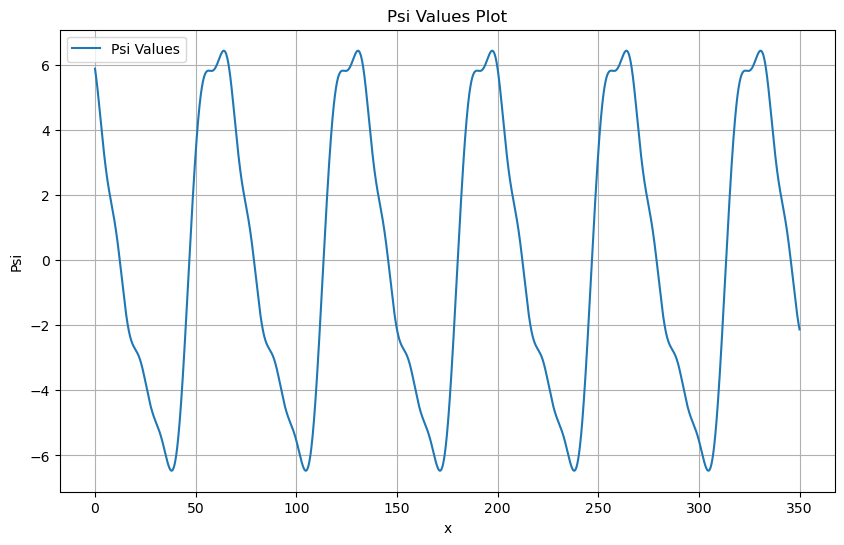

In [5]:
# Build Psi values for plotting
psiVals = buildPsiVals(kpsi_vals, coeffs_vals, x_range)

# Plot Psi values
plt.figure(figsize=(10, 6))
plt.plot(x_range, psiVals, label="Psi Values")
plt.xlabel("x")
plt.ylabel("Psi")
plt.title("Psi Values Plot")
plt.grid(True)
plt.legend()
plt.show()


## Get Model Output

In [6]:
data_df = pd.read_csv(signal_path, dtype = str)

data_df = data_df.dropna(axis = 1, how = 'any')

data_matrix = data_df.applymap(convert_to_complex).to_numpy().T

data_matrix_split = split_complex_to_imaginary(data_matrix)

print("Data Matrix Split Shape:", data_matrix_split.shape)


sample_signal = data_matrix_split[0,:]

print(sample_signal)

Data Matrix Split Shape: (100, 2882)
[0. 0. 0. ... 0. 0. 0.]


/tmp/ipykernel_1491746/1468706982.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data_matrix = data_df.applymap(convert_to_complex).to_numpy().T


In [7]:
with open('/home/houtlaw/iono-net/model/model_params_20241104_220235.pkl', 'rb') as f:
    params = pickle.load(f)

# Define the model with the same architecture as used in training
architecture = [1024,512,256,238,64,32] 
activation_fn = jax.numpy.tanh  # Load from config if required
model = ConfigurableModel(architecture=architecture, activation_fn=activation_fn)


#data_matrix = data_df.applymap(convert_to_complex).to_numpy().T 
#kpsi_vals = kpsi_df.iloc[:, 0].values

sample_data = signal_df.iloc[0,:].values

# Run inference
def run_inference(model, params, input_data):
    output = model.apply({'params': params}, input_data, deterministic=True)
    return output

In [8]:
sample_output = run_inference(model, params, sample_signal)

2024-11-07 11:51:20.010018: W external/xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version 12.6.77. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [9]:
print(sample_output)

[ 5.754923   -0.3408357  -0.11140503  0.34377187  0.0520947   0.10172909
  1.8113631   1.4030722  -0.6556461   0.01252385  0.23811202  0.08371398]


In [10]:
sample_output_complex = sample_output[:len(sample_output)//2] + 1j*sample_output[len(sample_output)//2:]
print(sample_output_complex)

[ 5.754923  +1.8113631j  -0.3408357 +1.4030722j  -0.11140503-0.6556461j
  0.34377187+0.01252385j  0.0520947 +0.23811202j  0.10172909+0.08371398j]


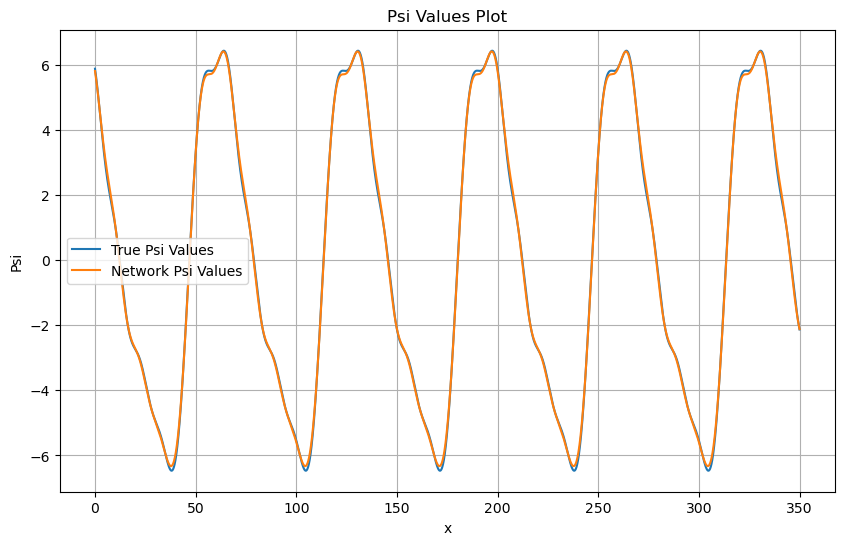

In [12]:
# Build Psi values for plotting
model_psiVals = buildPsiVals(kpsi_vals, sample_output_complex, x_range)

# Plot Psi values
plt.figure(figsize=(10, 6))
plt.plot(x_range, psiVals, label= "True Psi Values")
plt.plot(x_range, model_psiVals, label="Network Psi Values")
plt.xlabel("x")
plt.ylabel("Psi")
plt.title("Psi Values Plot")
plt.grid(True)
plt.legend()
plt.show()


# Evaluating Model Output

In [ ]:
def evaluate_image(domain, window_func, signal, psi_obj, F=100, dx=0.25):
    """
    Evaluate the image integral for all points using the given domain and parameters.

    Parameters:
    - domain: array-like, the spatial domain over which to compute the image
    - window_func: function, windowing function to apply on the signal
    - signal: np.ndarray, the signal data where signal[0, :] is the real part, signal[1, :] is the complex part
    - psi_obj: object with method `calc_psi_cache(y)` to apply phase modifications
    - F: float, optional, frequency parameter, default is 100
    - dx: float, optional, spacing for integration, default is 0.25

    Returns:
    - imag_val: np.ndarray, the computed image matrix values
    """
    real_signal = np.real(signal[0, :])
    imag_val = np.empty_like(signal[1, :], dtype='complex128')
    integrand_cache = {}

    for yidx, y in enumerate(domain):
        x0 = max(real_signal[0], y - F / 2)
        x1 = min(real_signal[-1], y + F / 2)
        mask = (real_signal >= x0) & (real_signal <= x1)

        base = real_signal[mask]
        signal_vals = signal[1, mask]
        waveform = np.exp(-1j * np.pi * (base - y) ** 2 / F)
        psi_vals = np.exp(1j * psi_obj.calc_psi_cache(y))
        window = window_func(base)

        without_psi_heights = waveform * signal_vals * window
        integrand_cache[y] = without_psi_heights
        heights = without_psi_heights * psi_vals

        imag_val[yidx] = np.trapz(heights, base, dx) / F

    return imag_val